In [22]:
%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

import os
import torch

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from csng.imagenet.models import ReadIn, ResnetExtractor, UpsampleModel, count_parameters
import datetime

assert torch.cuda.is_available()

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [ ]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 80
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
MODEL_PATH = '/scratch/izar/vanousek/cs-433-project/models/'
RESNET_DECODE_MODEL = os.path.join(MODEL_PATH, 'mlp2489100.pt')

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [24]:
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [6],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['test']))

71 1


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 8587])
6


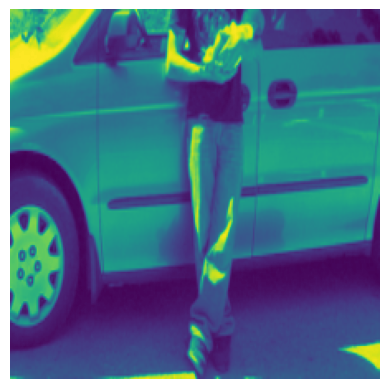

In [25]:
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 


In [26]:
readin = ReadIn(neurons, (1024, 14, 14))
readin.to(device, dtype=READIN_DTYPE)
    

params = count_parameters(readin)
print("Total parametrs: ", params)


Total parametrs:  220345344


In [ ]:

optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)

extractor = ResnetExtractor()

losses = []


for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        with torch.cuda.amp.autocast():
            pass
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(readin.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        losses.append(relative_loss)
        # print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished with relative loss {np.mean(losses[-len(dl['train']):])}")



Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
  0%|                                           | 0/71 [00:00<?, ?it/s]/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████████████████████████████▌| 70/71 [01:21<00:00,  1.00it/s]/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 20, 1024, 14, 14])) that is different to the input size (torch.Size([20, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target

Epoch 0 finished with relative loss 3.874543727331335


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.32it/s]


Epoch 1 finished with relative loss 0.3820047255592649


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 2 finished with relative loss 0.2264891104059299


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 3 finished with relative loss 0.2180393670018319


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.32it/s]


Epoch 4 finished with relative loss 0.21180603074478482


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 5 finished with relative loss 0.20544248680864913


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 6 finished with relative loss 0.1992242412373166


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 7 finished with relative loss 0.19219995303769583


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 8 finished with relative loss 0.18638122805309865


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 9 finished with relative loss 0.1809041100194228


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 10 finished with relative loss 0.17506874056269323


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.32it/s]


Epoch 11 finished with relative loss 0.16879186491434703


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 12 finished with relative loss 0.16310943479243034


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 13 finished with relative loss 0.15771129881721976


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 14 finished with relative loss 0.15203022277819903


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 15 finished with relative loss 0.14649589356535192


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 16 finished with relative loss 0.14128925024519018


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 17 finished with relative loss 0.13666827339263818


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 18 finished with relative loss 0.13180636993125844


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 19 finished with relative loss 0.12737759593622458


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 20 finished with relative loss 0.12344271303787545


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 21 finished with relative loss 0.11900519429326803


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 22 finished with relative loss 0.11531669646592468


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 23 finished with relative loss 0.1113182199000096


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 24 finished with relative loss 0.10826320949286815


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 25 finished with relative loss 0.1049189681885398


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 26 finished with relative loss 0.10160581461724112


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 27 finished with relative loss 0.09871686160746863


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 28 finished with relative loss 0.09547957100734772


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 29 finished with relative loss 0.09288967466167009


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 30 finished with relative loss 0.09039372608955591


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 31 finished with relative loss 0.08825059195873275


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 32 finished with relative loss 0.08607594743246196


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 33 finished with relative loss 0.0836864113845469


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 34 finished with relative loss 0.08145480975026026


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 35 finished with relative loss 0.07955237619538559


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 36 finished with relative loss 0.07773032174206405


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 37 finished with relative loss 0.07592519252139628


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 38 finished with relative loss 0.07432992316480544


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 39 finished with relative loss 0.07284019149650953


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 40 finished with relative loss 0.07181067783728154


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 41 finished with relative loss 0.07024557211345366


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 42 finished with relative loss 0.06870232989741973


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 43 finished with relative loss 0.06749760100928327


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 44 finished with relative loss 0.06645943506505127


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 45 finished with relative loss 0.0653875909485163


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 46 finished with relative loss 0.06408869493016806


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 47 finished with relative loss 0.06286052146817392


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 48 finished with relative loss 0.062172491209496465


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 49 finished with relative loss 0.061071942330235184


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 50 finished with relative loss 0.060396132058306844


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 51 finished with relative loss 0.05947284897490256


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 52 finished with relative loss 0.059033606997621106


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 53 finished with relative loss 0.058131824281397834


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 54 finished with relative loss 0.057824337469726726


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 55 finished with relative loss 0.05704504398344162


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 56 finished with relative loss 0.05658499995825023


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 57 finished with relative loss 0.05606049125373322


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 58 finished with relative loss 0.05561504718887704


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 59 finished with relative loss 0.0555318772309645


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 60 finished with relative loss 0.05501833646005754


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 61 finished with relative loss 0.05442426193796402


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.33it/s]


Epoch 62 finished with relative loss 0.05419537562933937


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 63 finished with relative loss 0.05407219524494597


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 64 finished with relative loss 0.053593922683645934


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 65 finished with relative loss 0.053329581070236866


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 66 finished with relative loss 0.053253219185397965


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 67 finished with relative loss 0.0531432059163911


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 68 finished with relative loss 0.05285808042433244


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 69 finished with relative loss 0.0528942948855448


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 70 finished with relative loss 0.052485801318672344


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.34it/s]


Epoch 71 finished with relative loss 0.052352660693929076


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.37it/s]


Epoch 72 finished with relative loss 0.05212682184244583


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 73 finished with relative loss 0.05204989354874562


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 74 finished with relative loss 0.05184695161215674


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.35it/s]


Epoch 75 finished with relative loss 0.052036491708452225


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.37it/s]


Epoch 76 finished with relative loss 0.0516461432994103


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.38it/s]


Epoch 77 finished with relative loss 0.051599597278155426


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.36it/s]


Epoch 78 finished with relative loss 0.05150610438439146


100%|██████████████████████████████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 79 finished with relative loss 0.051519540638486704


Text(0.5, 0, 'Batch')

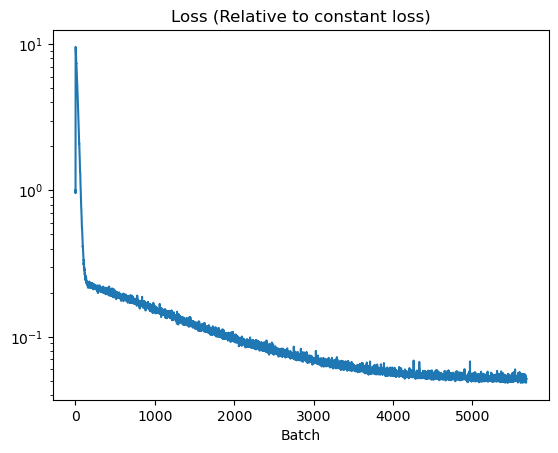

In [ ]:
# Plot losses
plt.plot(losses)
plt.yscale('log')

plt.title('Loss (Relative to constant loss)')
plt.xlabel('Batch')

In [616]:
readin_models_path = os.path.join(MODEL_PATH, "readin")
if not os.path.exists(readin_models_path):
    os.makedirs(readin_models_path)

# Switch based on whether you want to save the model
if True: # Save the model
# if False: # Load last model
    # Save the model
    model_path = os.path.join(readin_models_path, f"readin_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pt")
    print(f"Saving model to {model_path}")
    torch.save(readin,model_path)
else:

    model_path = os.path.join(readin_models_path, os.listdir(readin_models_path)[-1])
    readin = torch.load(model_path)
    print(f"Loaded model from {model_path}")

NameError: name 'model_path' is not defined

In [617]:
# Evaluate the model
readin.eval()
test_losses = []
imgs = []
imgnet_activations_real = []
imgnet_activations_pred = []

with torch.no_grad():
    for minibatch in dl['test']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        test_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)
        imgs.append(stim)

        print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")
# .22
print(f"Mean loss: {np.mean(test_losses)}")
print(f"Std loss: {np.std(test_losses)}")

/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 0.007293701171875 Constant loss: 0.1162109375 Relative loss: 0.06276206497181067
Loss: 0.007293701171875
Loss: 0.007293701171875 Constant loss: 0.1181640625 Relative loss: 0.06172468424730025
Loss: 0.007293701171875
Mean loss: 0.06224337460955546
Std loss: 0.0005186903622552072


/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 36, 1024, 14, 14])) that is different to the input size (torch.Size([36, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([64, 1, 224, 224])
tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
        

<Figure size 640x480 with 0 Axes>

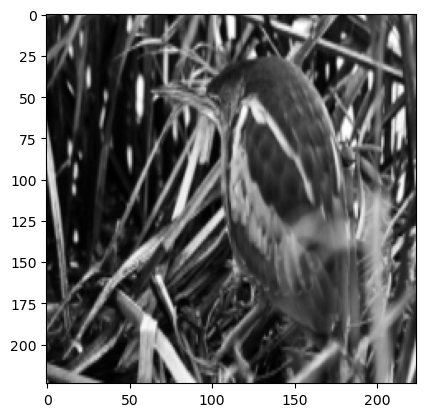

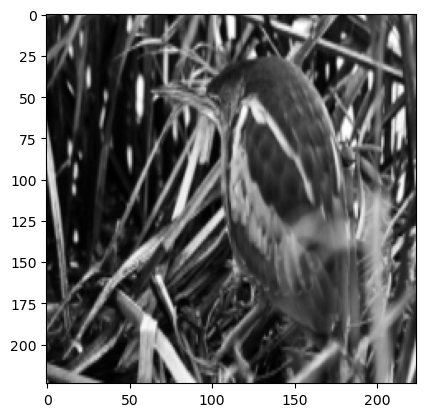

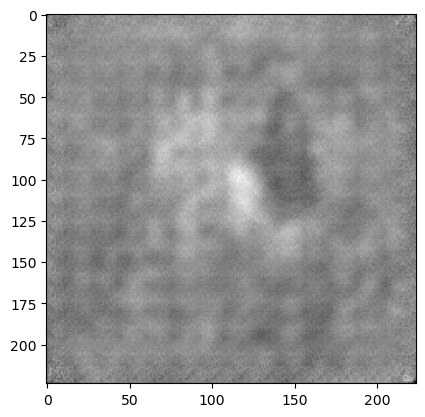

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

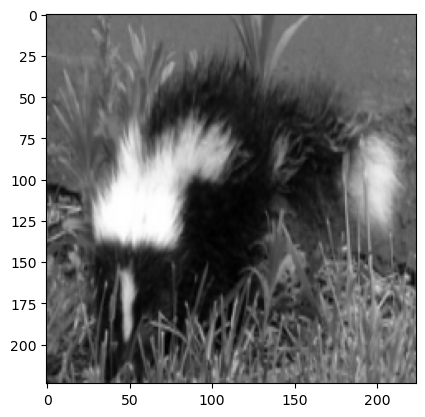

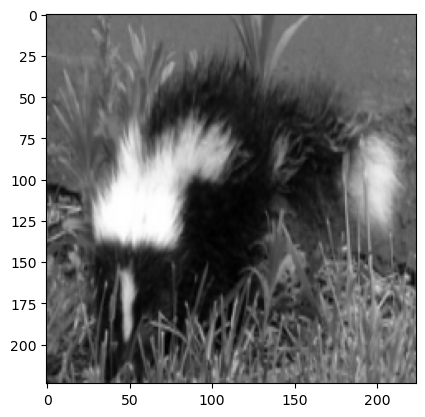

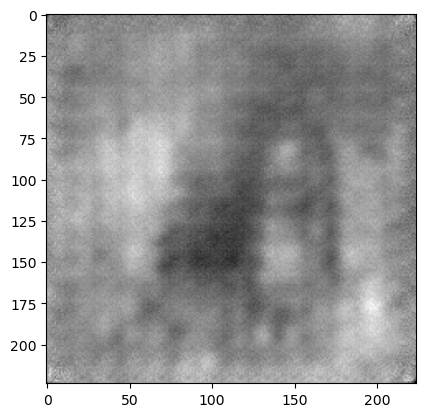

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

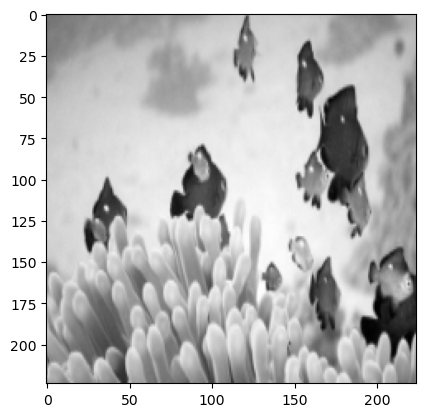

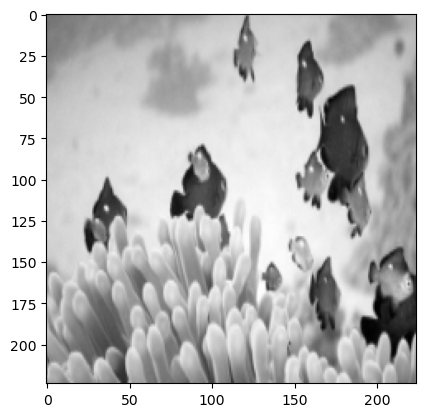

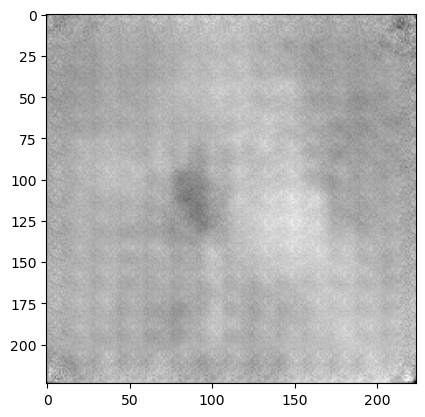

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

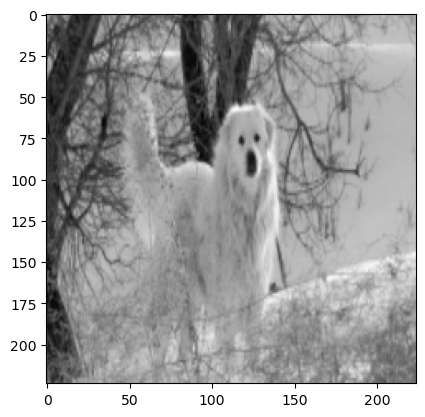

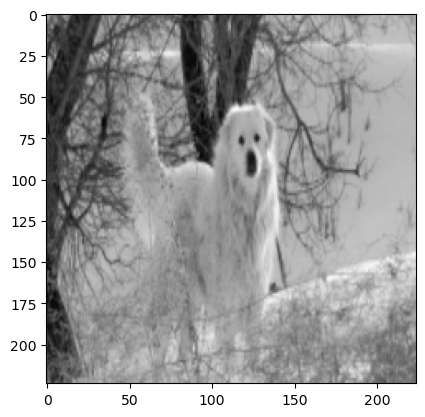

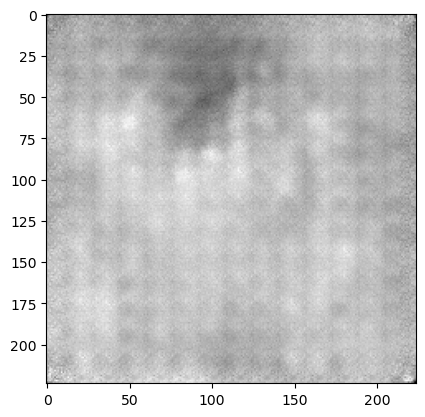

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

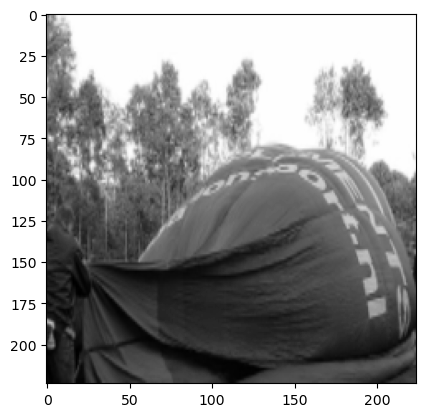

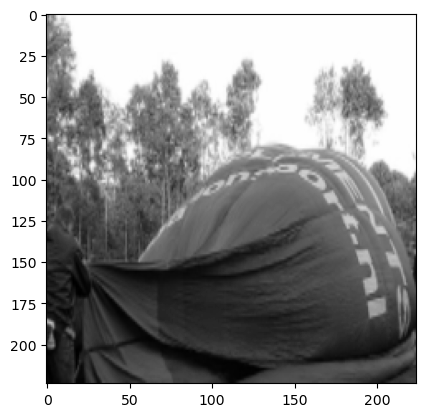

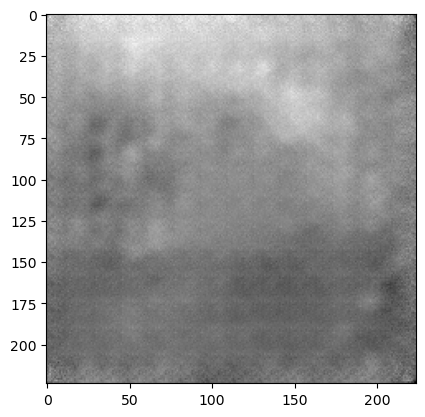

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

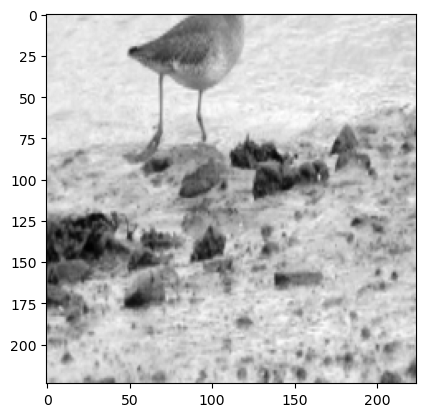

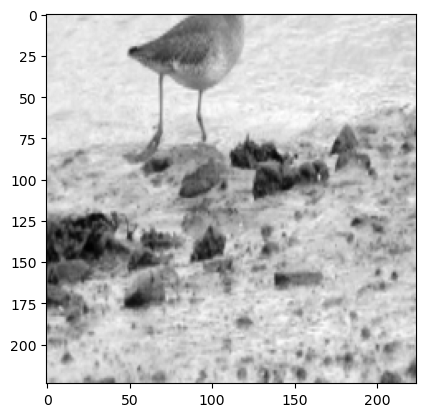

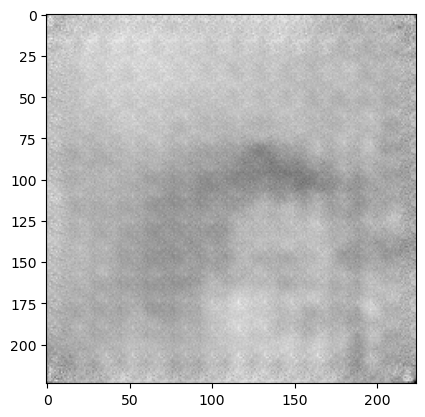

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

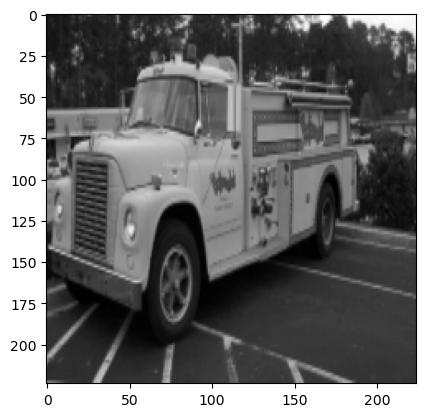

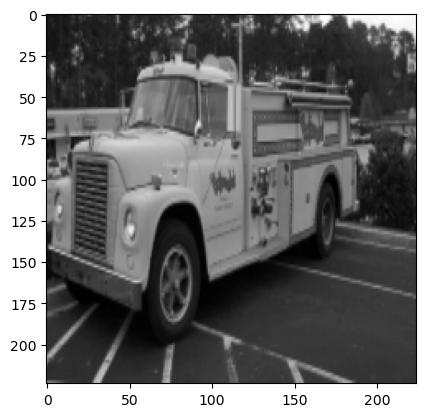

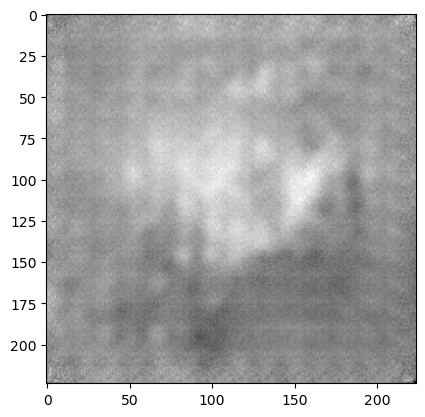

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

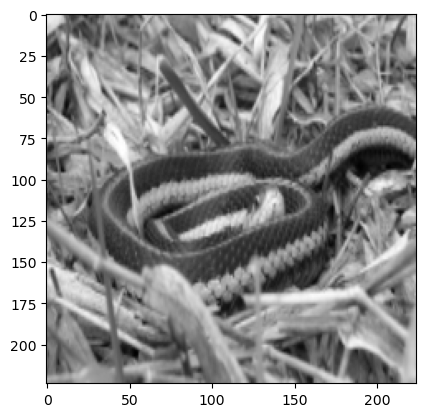

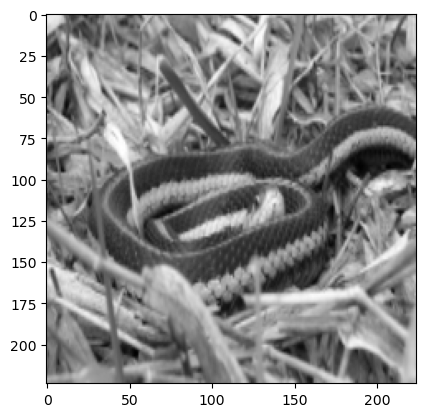

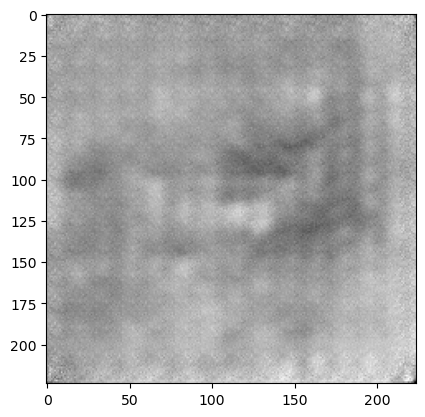

tensor([[[[0.1843, 0.3922, 0.3647,  ..., 0.2235, 0.2118, 0.2275],
          [0.1843, 0.3098, 0.2588,  ..., 0.3333, 0.3451, 0.2510],
          [0.1804, 0.2039, 0.1294,  ..., 0.4627, 0.5137, 0.2863],
          ...,
          [0.2863, 0.2745, 0.2510,  ..., 0.3137, 0.3804, 0.4314],
          [0.2941, 0.2588, 0.2588,  ..., 0.2627, 0.2980, 0.3882],
          [0.3020, 0.2431, 0.2627,  ..., 0.2235, 0.2392, 0.3569]]],


        [[[0.3451, 0.2980, 0.3843,  ..., 0.5020, 0.3686, 0.3098],
          [0.3569, 0.3020, 0.3098,  ..., 0.4431, 0.3412, 0.3098],
          [0.3451, 0.2863, 0.2078,  ..., 0.3765, 0.3059, 0.3176],
          ...,
          [0.3098, 0.1529, 0.1725,  ..., 0.6314, 0.3176, 0.2471],
          [0.5725, 0.2431, 0.1216,  ..., 0.5294, 0.2824, 0.2353],
          [0.7882, 0.3294, 0.0863,  ..., 0.4549, 0.2627, 0.2314]]],


        [[[0.4667, 0.4549, 0.4549,  ..., 0.5294, 0.5255, 0.5137],
          [0.4627, 0.4549, 0.4549,  ..., 0.5137, 0.5137, 0.5098],
          [0.4549, 0.4549, 0.4549,  ..

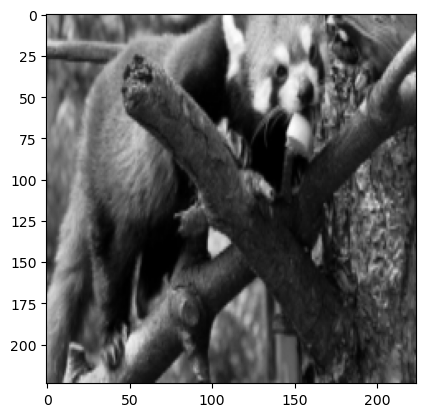

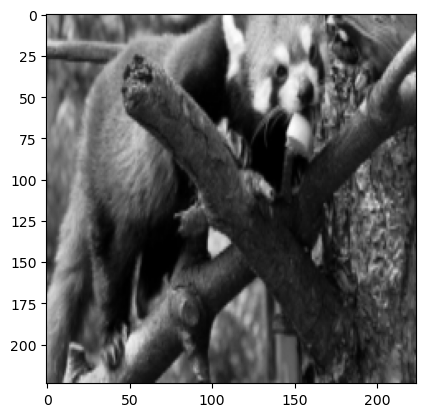

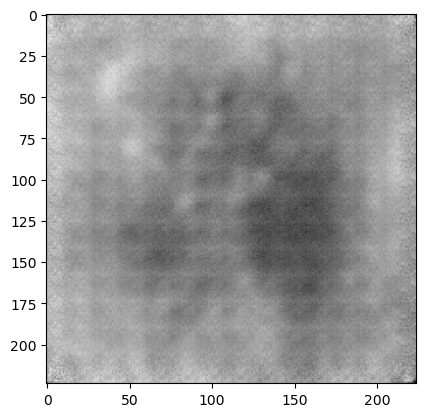

torch.Size([36, 1, 224, 224])
tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
        

<Figure size 640x480 with 0 Axes>

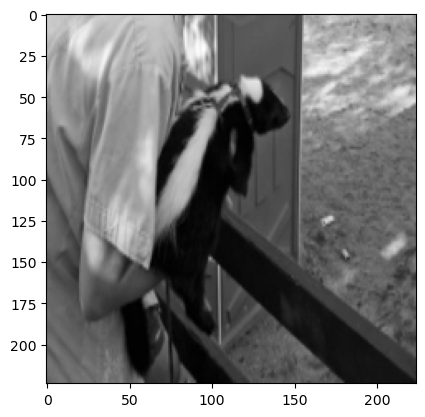

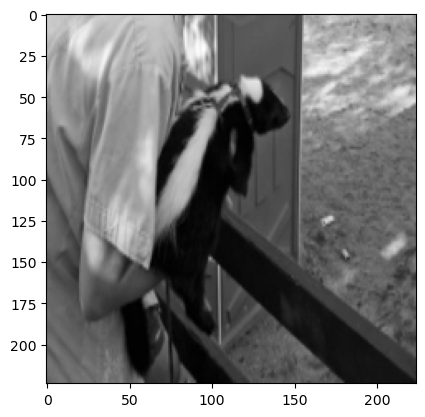

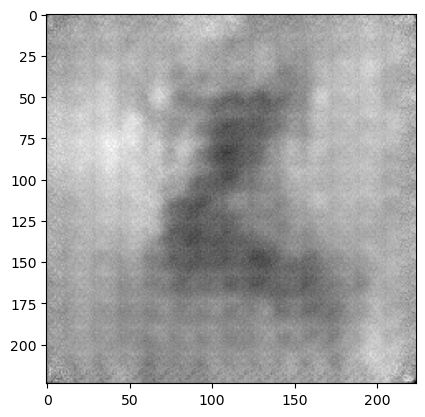

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

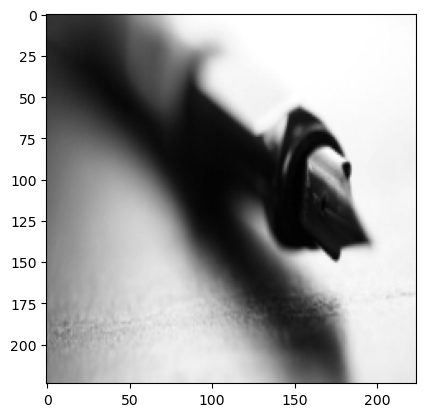

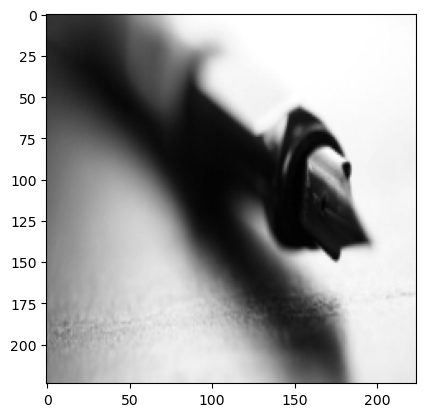

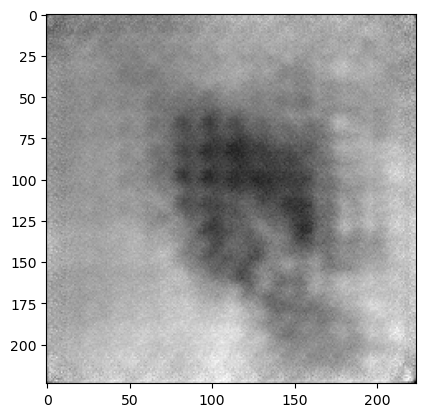

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

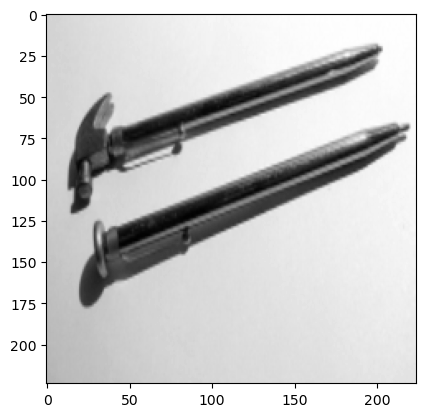

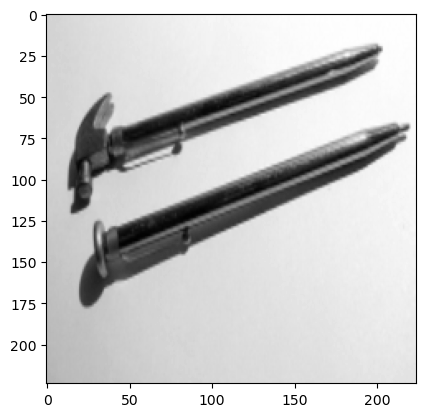

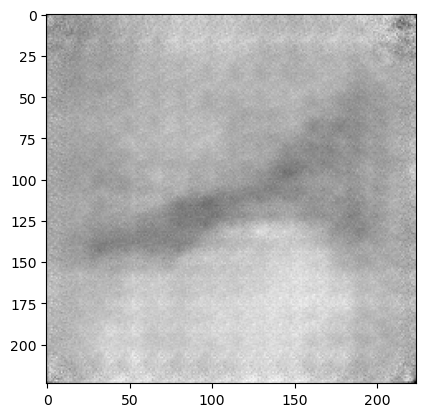

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

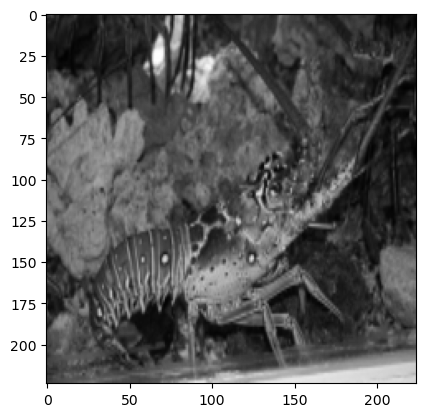

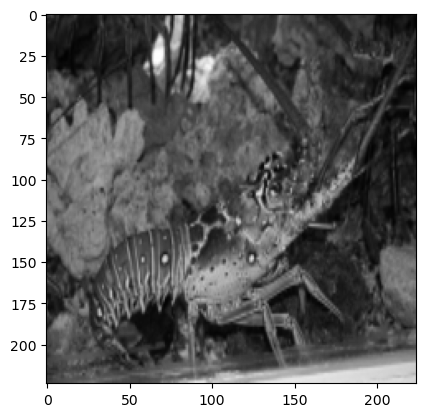

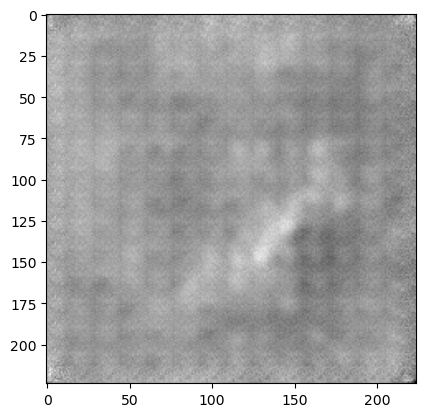

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

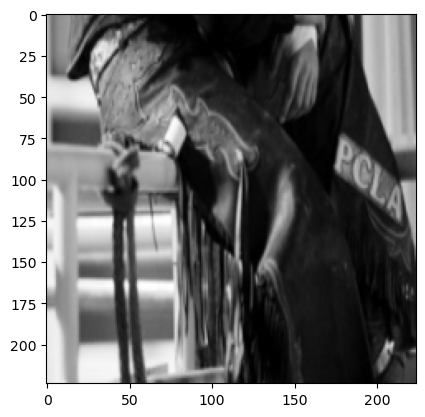

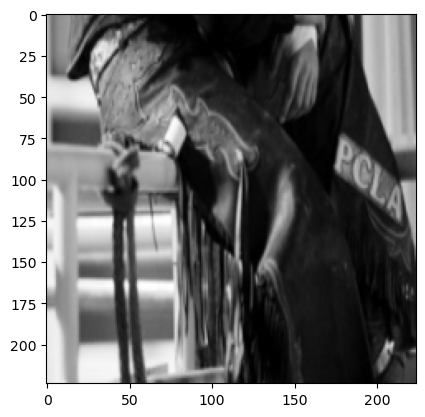

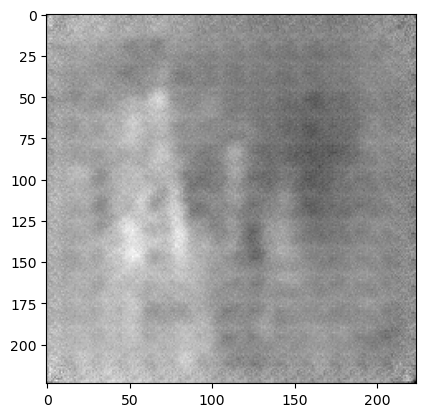

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

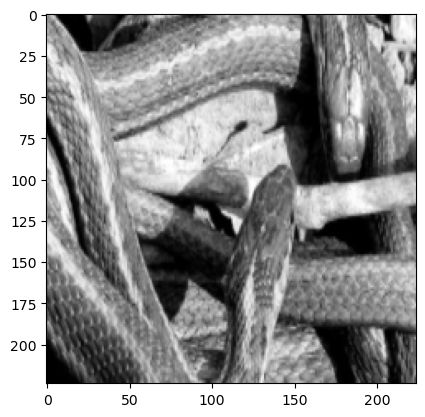

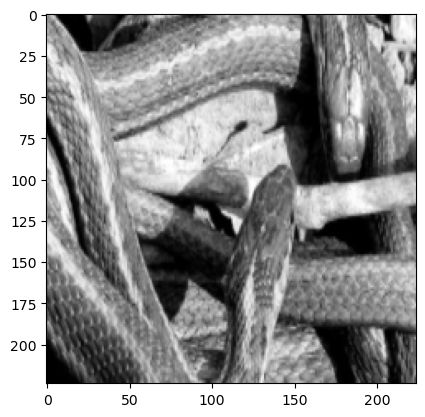

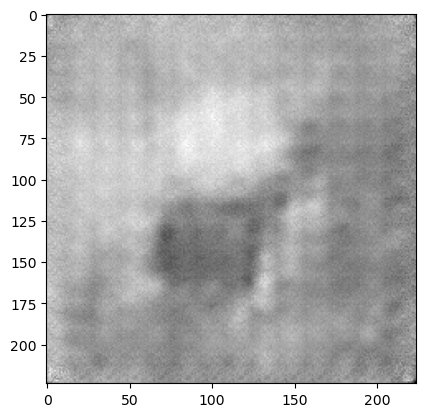

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

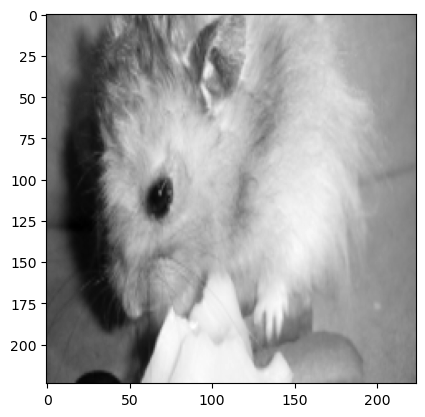

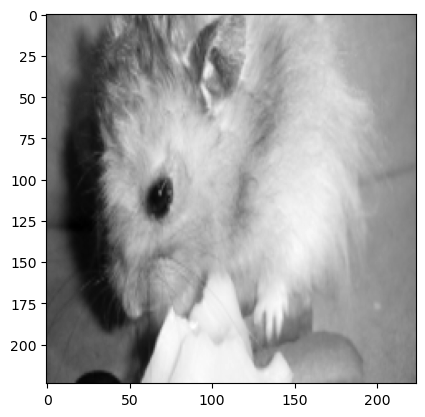

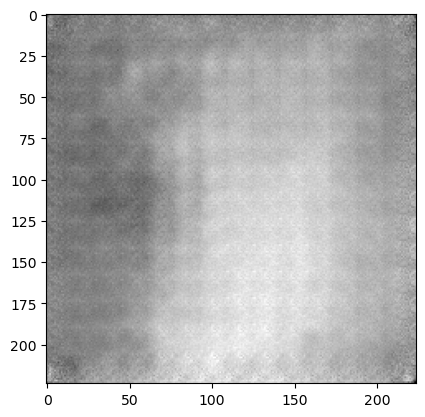

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

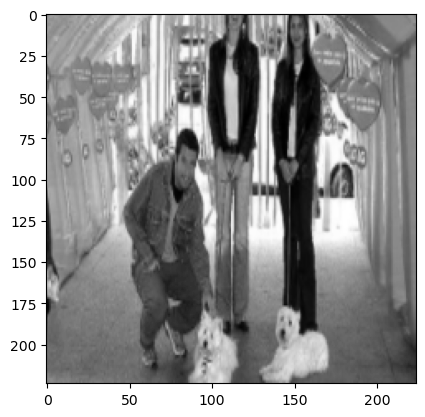

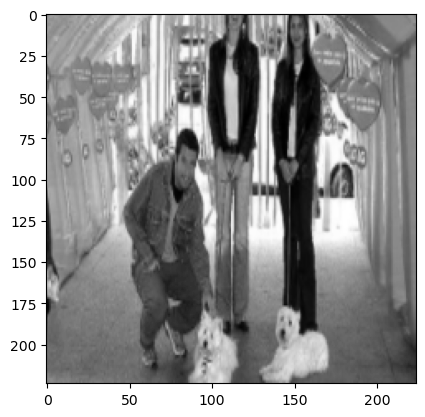

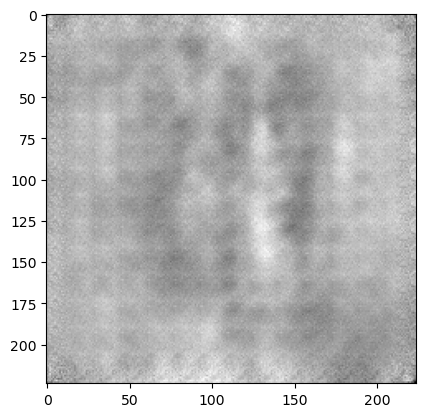

tensor([[[[0.6314, 0.6196, 0.6118,  ..., 0.6275, 0.6118, 0.6353],
          [0.6510, 0.6431, 0.6431,  ..., 0.6353, 0.6196, 0.6392],
          [0.6706, 0.6627, 0.6745,  ..., 0.6431, 0.6314, 0.6431],
          ...,
          [0.4824, 0.4941, 0.5059,  ..., 0.7686, 0.7608, 0.7686],
          [0.4784, 0.4863, 0.4941,  ..., 0.7451, 0.7451, 0.7333],
          [0.4784, 0.4784, 0.4863,  ..., 0.7294, 0.7333, 0.7098]]],


        [[[0.7490, 0.7412, 0.7451,  ..., 0.6863, 0.6627, 0.5647],
          [0.7451, 0.7412, 0.7451,  ..., 0.6627, 0.6157, 0.5490],
          [0.7412, 0.7412, 0.7412,  ..., 0.6275, 0.5608, 0.5373],
          ...,
          [0.3765, 0.3922, 0.4000,  ..., 0.1373, 0.1765, 0.2157],
          [0.3725, 0.3843, 0.3922,  ..., 0.1137, 0.1373, 0.1647],
          [0.3686, 0.3804, 0.3882,  ..., 0.1059, 0.1098, 0.1216]]],


        [[[0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2510, 0.2588, 0.2588,  ..., 0.9725, 0.9686, 0.9686],
          [0.2549, 0.2588, 0.2588,  ..

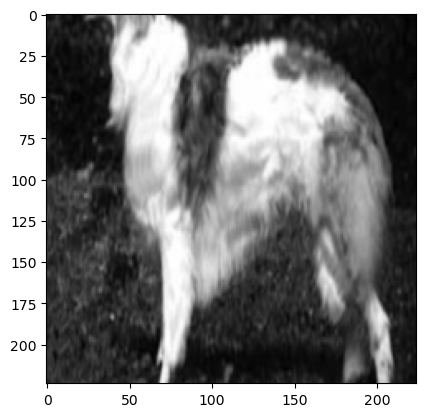

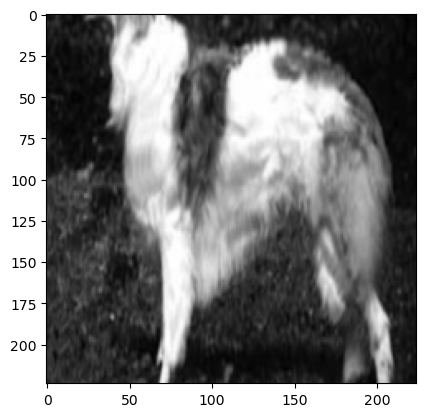

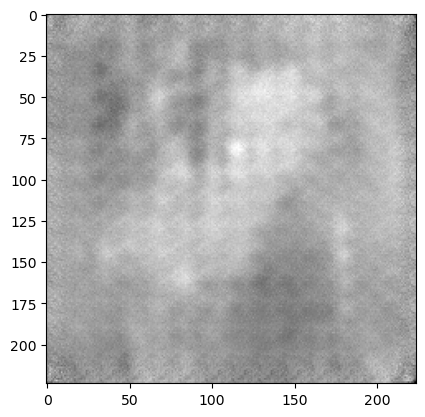

In [ ]:

output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
for real, recon, pred in zip(imgs, imgnet_activations_real, imgnet_activations_pred):
    plt.figure()
    with torch.no_grad():
        real_img = real
        print(real_img.shape)
        for i in range(real_img.shape[0]):
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
            plt.figure()
            plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.show()